In [1]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
from unyt import MWh, kWh

## PyPSA Network

In [58]:
n = pypsa.Network(name='Armourdale')

N_days=365
N_hours=24

index = pd.date_range(start="2018-01-01", 
                      periods=N_days*N_hours, 
                      freq='h')

n.set_snapshots(index)

Step 1: Add buses

In [59]:
bus_name = 'Residential'
n.add(class_name='Bus',
      name=bus_name,
      carrier='AC')

Step 2: Add energy carriers

In [60]:
n.add(class_name="Carrier", name="grid")
n.add(class_name="Carrier", name="solar")
n.add(class_name="Carrier", name="battery")
n.add(class_name="Carrier", name='net metering')

Step 3: Add load

In [61]:
load = pd.read_csv("../data/timeseries/residential_elec_load_rescaled.csv", parse_dates=True, index_col='timestamp')

In [62]:
load_resampled = load.loc['2018'].resample('h').mean().sum(axis=1)
load_resampled = load_resampled / 1e3  # kW --> MW

In [63]:
n.add(
    class_name="Load",
    name=f"Load {bus_name}",
    bus=bus_name,
    p_set=load_resampled
)

Step 3: Add weather data

In [64]:
weather = pd.read_csv("../data/timeseries/weather_year.csv", parse_dates=True, index_col=0)
weather.head()

,date_time,temp_db,rel_humidity,wind_speed,wind_direction,ghi,dni,dhi
2018-01-01 00:00:00,2005-01-01 01:00:00,8.0,61,5.7,80,0,0,0
2018-01-01 01:00:00,2005-01-01 02:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 02:00:00,2005-01-01 03:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 03:00:00,2005-01-01 04:00:00,7.0,56,6.2,80,0,0,0
2018-01-01 04:00:00,2005-01-01 05:00:00,7.0,56,5.1,90,0,0,0


In [65]:
# normalize GHI
ghi = weather['ghi'] / weather['ghi'].max()

Step 4: Upload cost data

In [66]:
costs = pd.read_csv("../data/technology_costs.csv", index_col='technology')

In [67]:
costs *= 1e3  # convert /kW to /MW
costs

,Fixed O&M,OCC
technology,,
DistributedWind,35912.100000,5.678577e+06
ResPV,28108.825392,2.630889e+06
Residential Battery Storage,78943.789878,3.157752e+06


Step 5: Add generators to network

In [68]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n)

In [69]:
annuity_adj = annuity(0.07, 20)
annuity_adj

0.09439292574325567

In [70]:
costs = costs.assign(annualized_cost = costs['OCC']*annuity_adj + costs['Fixed O&M'])
costs

,Fixed O&M,OCC,annualized_cost
technology,,,
DistributedWind,35912.100000,5.678577e+06,571929.570926
ResPV,28108.825392,2.630889e+06,276446.116985
Residential Battery Storage,78943.789878,3.157752e+06,377013.201712


In [71]:
for generator in costs.index:
    if generator == 'DistributedWind':
        pass
    else:
        print(generator)
        annualized_cost = costs.at[generator, 'annualized_cost']
        print(annualized_cost)
        
        if generator=='ResPV':
            n.add(class_name='Generator',
                    name=generator,
                    bus=bus_name,
                    carrier="solar",
                    capital_cost=annualized_cost,  # $/kW
                    p_min_pu=ghi,
                    p_max_pu=ghi,
                    p_nom_extendable=True,
                    p_nom_max = 2.807,
                    )
        elif generator=='Residential Battery Storage':
            pass
            n.add(class_name="StorageUnit",
                    name=generator,
                    bus=bus_name,
                    carrier="battery",
                    capital_cost=annualized_cost,  # $/kW
                    p_nom_extendable=True,
                    max_hours=2.5,
                    cyclic_state_of_charge=False,
                    )
        
        

ResPV
276446.11698458303
Residential Battery Storage
377013.20171200635


Add a "net metering" technology to capture the excess energy.

In [72]:
retail_price = 112.9  # $/MWh

In [73]:
n.add(class_name="Generator",
      name=f"Net metering {bus_name}",
      bus=bus_name,
      carrier='net metering',
      p_min_pu=-1,
      p_max_pu=0.0,
      marginal_cost=retail_price*0.0,
      capital_cost=0.0,
      p_nom_extendable=True)

In [74]:
n.add(class_name='Generator',
      name='Evergy Import',
      bus=bus_name,
      carrier='grid',
      capital_cost=0,
      marginal_cost=retail_price,
      p_nom_extendable=True,
      # p_nom_max=1.3315
      )

In [75]:
n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
ResPV,Residential,PQ,,0.0,0.0,True,0.0,2.807,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Net metering Residential,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Evergy Import,Residential,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


## Model Version: Baseline

At this moment, the model

* uses the sticker price for rooftop solar from NREL's ATB
* does NOT pay for net metering
* does NOT include residential storage

Step 6: Run the model

In [76]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 69.63it/s]
INFO:linopy.io: Writing time: 0.58s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [77]:
results_1 = n.statistics().copy()
results_1

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Dispatch,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,1.430806,0.0,4135.96535,0.00000,4135.96535,0.0,0.329983,0.0,0.0,466950.487985,466950.487985,112.9
Load,-,0.000000,0.0,0.00000,4135.96535,-4135.96535,0.0,NaN,0.0,0.0,0.000000,-466950.487985,NaN


In [101]:
n.storage_units.p_nom_opt

StorageUnit
Residential Battery Storage   -0.0
Name: p_nom_opt, dtype: float64

Step 7: Calculate the LCOE from the model

In [21]:
model_lcoe_1 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_1

112.9000000000018

We observe that the model has an LCOE of $112.9/MWh, which makes sense because it only uses electricity purchased from the grid.

Step 8: Plot some data

<Axes: xlabel='snapshot'>

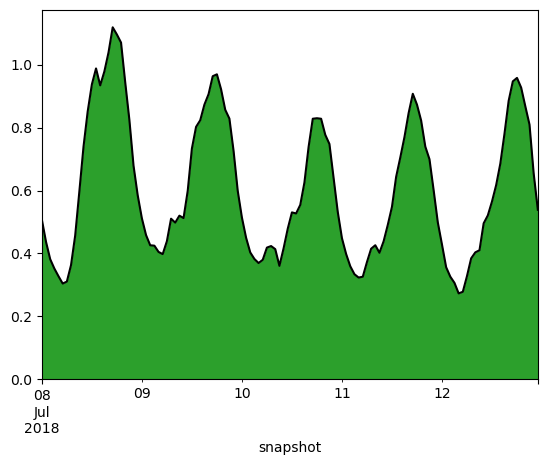

In [22]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)


## Model Version: Tax Credit Simulation

At this moment, the model

* does NOT pay for net metering

The purpose of this simulation is to test the effect of price reductions on solar penetration.

In [80]:
data = {'discount':[],
        'solar_capacity':[]}

discounts = np.linspace(0, 1, 20)

for discount in discounts:
        n.generators.loc['ResPV', 'capital_cost'] = costs.at['ResPV','annualized_cost'] * (1-discount)
        
        n.optimize(solver_name='highs')
        
        data['discount'].append(discount)
        data['solar_capacity'].append(np.abs(n.generators.p_nom_opt['ResPV']))

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 53.99it/s]
INFO:linopy.io: Writing time: 0.83s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [0

In [82]:
results_df = pd.DataFrame(data)
results_df

,discount,solar_capacity
0,0.000000,0.000000
1,0.052632,0.000000
2,0.105263,0.000000
3,0.157895,0.000000
4,0.210526,0.000000
5,0.263158,0.000000
6,0.315789,0.000000
7,0.368421,0.000000
8,0.421053,0.366176
9,0.473684,0.479037


In [88]:
results_df = results_df.assign(solar_penetration=results_df['solar_capacity'] / n.generators.p_nom_max.ResPV)

(0.0, 1.0)

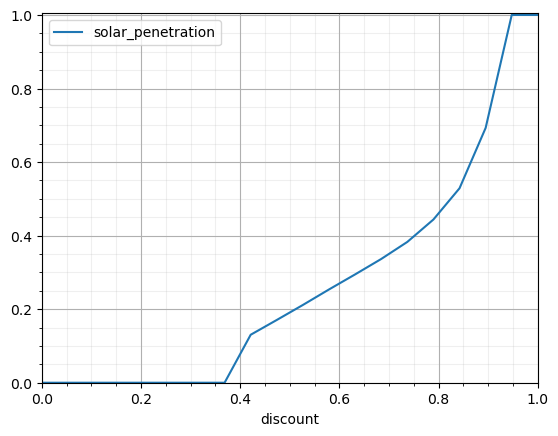

In [99]:
fig, ax = plt.subplots()
results_df.plot(ax=ax, x='discount', y='solar_penetration')
ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
ax.set_ylim(0,1.005)
ax.set_xlim(0,1.0)

In [104]:
data = {'discount':[],
        'percent_retail_price':[],
        'solar_capacity':[],
        'battery_capacity':[],
        'objective_value':[],
        }

discounts = np.linspace(0, 1, 20)
retail_prices = np.linspace(0, 1, 20)
for discount in discounts:
    for pct_retail in retail_prices:
        n.generators.loc['ResPV', 'capital_cost'] = costs.at['ResPV','annualized_cost'] * (1-discount)
        n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*pct_retail
        n.optimize(solver_name='highs')
        
        data['discount'].append(discount)
        data['solar_capacity'].append(np.abs(n.generators.p_nom_opt['ResPV']))
        data['battery_capacity'].append(np.abs(n.storage_units.p_nom_opt['Residential Battery Storage']))
        data['percent_retail_price'].append(pct_retail)
        data['objective_value'].append(n.objective)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 71.65it/s]
INFO:linopy.io: Writing time: 0.65s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [0

In [105]:
results_df_large = pd.DataFrame(data)
results_df_large

,discount,percent_retail_price,solar_capacity,battery_capacity,objective_value
0,0.0,0.000000,0.000,0.0,466950.487985
1,0.0,0.052632,0.000,0.0,466950.487985
2,0.0,0.105263,0.000,0.0,466950.487985
3,0.0,0.157895,0.000,0.0,466950.487985
4,0.0,0.210526,0.000,0.0,466950.487985
...,...,...,...,...,...
395,1.0,0.789474,2.807,0.0,56109.661027
396,1.0,0.842105,2.807,0.0,42098.770715
397,1.0,0.894737,2.807,0.0,28087.880403
398,1.0,0.947368,2.807,0.0,14076.990092


In [106]:
import seaborn as sb

In [107]:
results_df_large = results_df_large.assign(solar_penetration=results_df_large['solar_capacity'] / n.generators.p_nom_max.ResPV)


(0.0, 100.0)

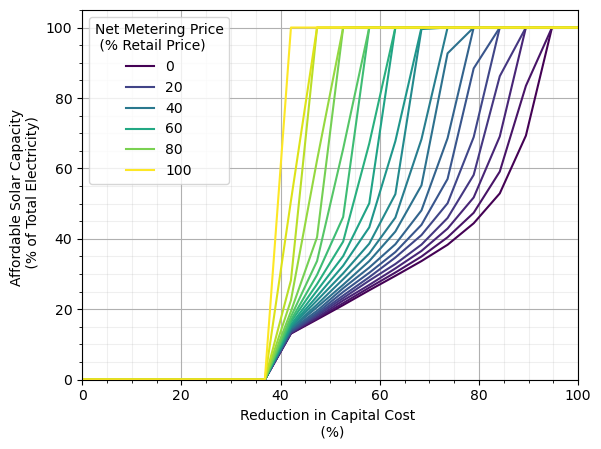

In [137]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large[['discount','solar_penetration','percent_retail_price']]*100,
            x='discount',
            y='solar_penetration',
            ax=ax,
            hue='percent_retail_price',
            palette='viridis')

ax.set_ylabel("Affordable Solar Capacity \n (% of Total Electricity)")
ax.set_xlabel("Reduction in Capital Cost \n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
ax.set_ylim(0,1.05*100)
ax.set_xlim(0,1.0*100)

In [134]:
results_df_large.describe()

,discount,percent_retail_price,solar_capacity,battery_capacity,objective_value,solar_penetration,lcoe
count,400.000000,400.000000,400.000000,400.0,400.000000,400.000000,400.000000
mean,0.500000,0.500000,1.218476,0.0,381557.144405,0.434085,0.092253
std,0.303869,0.303869,1.240130,0.0,117928.563407,0.441799,0.028513
min,0.000000,0.000000,0.000000,0.0,66.099781,0.000000,0.000016
25%,0.250000,0.250000,0.000000,0.0,317253.149899,0.000000,0.076706
50%,0.500000,0.500000,0.758327,0.0,449455.279045,0.270156,0.108670
75%,0.750000,0.750000,2.807000,0.0,466950.487985,1.000000,0.112900
max,1.000000,1.000000,2.807000,0.0,466950.487985,1.000000,0.112900


In [114]:
results_df_large = results_df_large.assign(lcoe=results_df_large['objective_value'] / n.loads_t.p_set.sum().values[0] / 1000)

(0.0, 1.0)

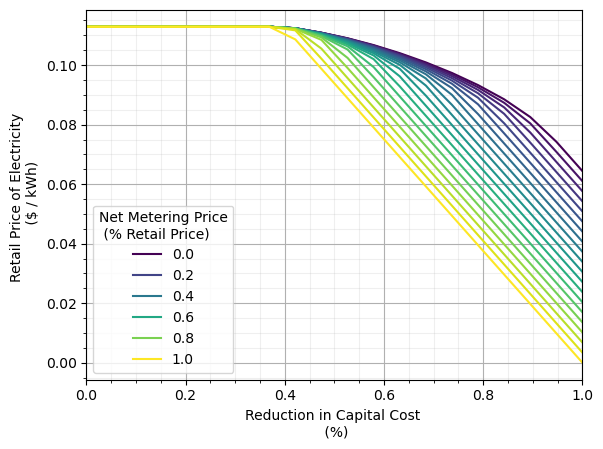

In [130]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large,
            x='discount',
            y='lcoe',
            ax=ax,
            hue='percent_retail_price',
            palette='viridis'
            )

ax.set_ylabel("Retail Price of Electricity \n ($ / kWh)")
ax.set_xlabel("Reduction in Capital Cost \n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
# ax.set_ylim(0,1.005)
ax.set_xlim(0,1.0)

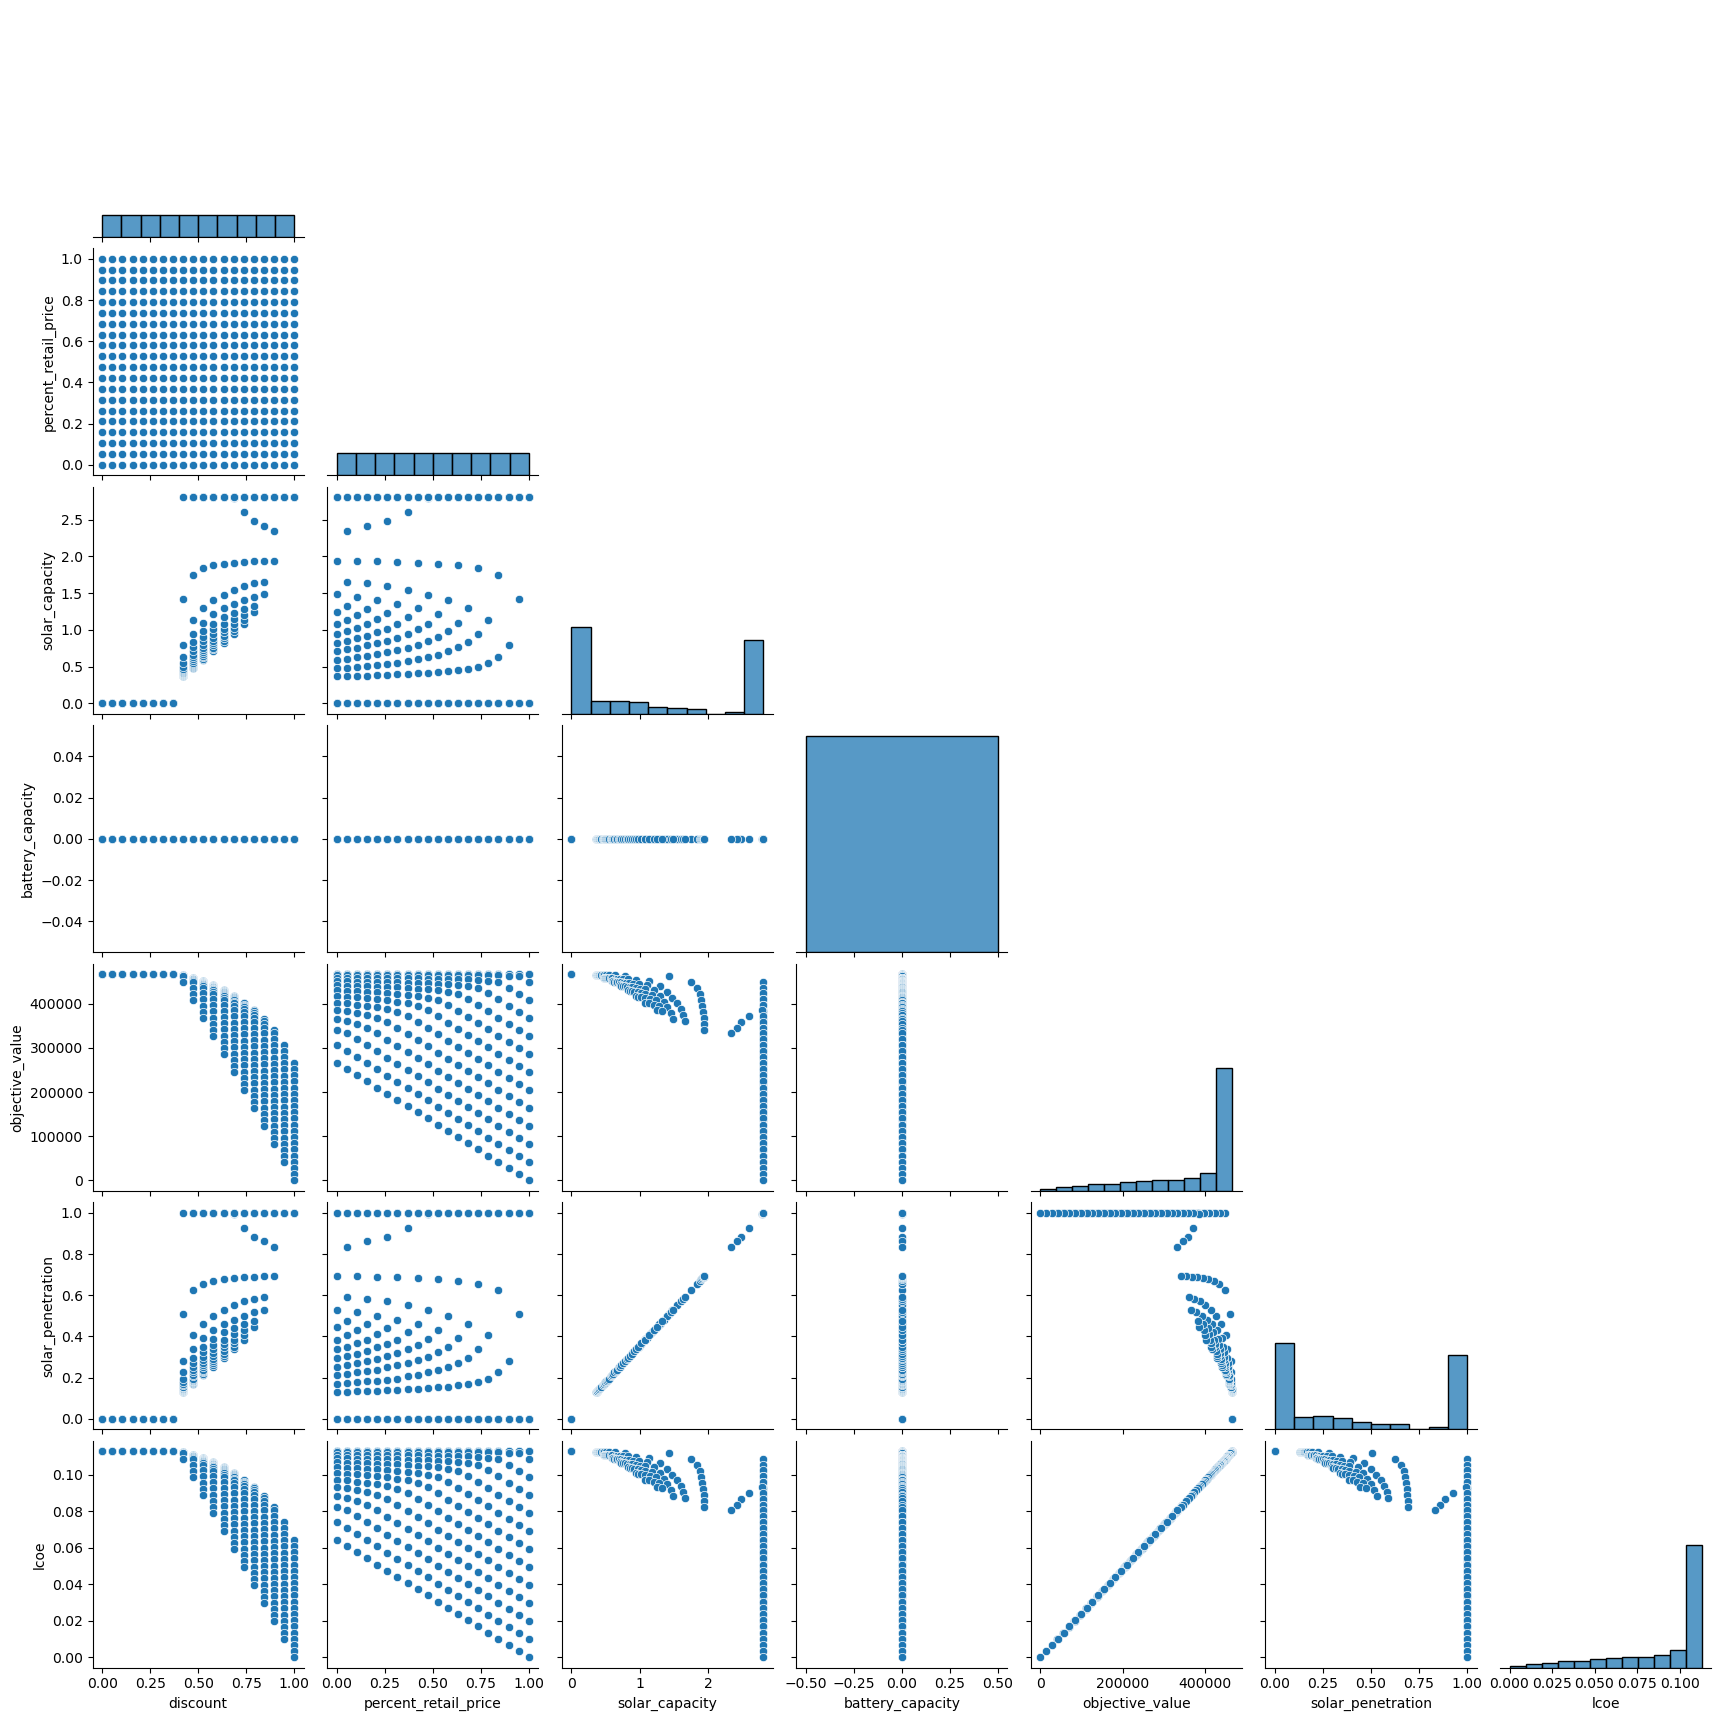

In [139]:
sb.pairplot(results_df_large, corner=True)

## Model Version: Net Metering

At this moment, the model

* uses the sticker price for rooftop solar from NREL's ATB
* applies 100% retail price for net metering
* does NOT include residential storage

In [23]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*1.0

In [24]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 71.10it/s]
INFO:linopy.io: Writing time: 0.62s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [25]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Dispatch,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,1.430806,0.0,4135.96535,0.00000,4135.96535,0.0,0.329983,0.0,0.0,466950.487985,466950.487985,112.9
Load,-,0.000000,0.0,0.00000,4135.96535,-4135.96535,0.0,NaN,0.0,0.0,0.000000,-466950.487985,NaN


In [26]:
model_lcoe_2 = n.objective / n.loads_t.p_set.sum()
model_lcoe_2

Load
Load Residential    112.9
dtype: float64

<Axes: xlabel='snapshot'>

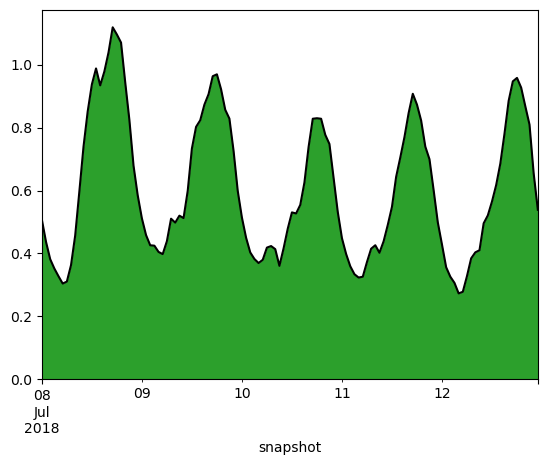

In [27]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)


## Model Version: Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* does NOT pay for net metering
* does NOT include residential storage

Apply the Residential Renewable Energy Tax Credit

[DSIRE Data on the RRETC](https://programs.dsireusa.org/system/program/detail/1235/residential-renewable-energy-tax-credit) -- solar and storage each get a 30% tax credit. 

Apply the Investment Tax Credit (ITC)

[EPA Data on ITC](https://www.epa.gov/green-power-markets/summary-inflation-reduction-act-provisions-related-renewable-energy) -- qualified residential units in a low-income area recieve +20%.

[Homeowner's Guide to Federal Tax Credits](https://www.energy.gov/eere/solar/homeowners-guide-federal-tax-credit-solar-photovoltaics).

This will be implemented as a direct 50% cost reduction.

In [28]:
# reset the price of net metering
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.0

In [29]:
rretc_credit = 0.5

In [30]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Residential Battery Storage,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.5,1.0,1.0,0.0,0.0,-0.0


In [31]:
n.generators.loc['ResPV', 'capital_cost'] *= (1-rretc_credit)
n.storage_units.loc['Residential Battery Storage', 'capital_cost'] *= (1-rretc_credit)

In [32]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 73.29it/s]
INFO:linopy.io: Writing time: 0.7s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.17e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [33]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.342852                 0.0  2964.049410   
          net metering          0.669086                 0.0     0.000000   
          solar                 0.947609                 0.0  1396.053259   
Load      -                     0.000000                 0.0     0.000000   

                        Withdrawal     Dispatch  Transmission  \
Generator grid             0.00000  2964.049410           0.0   
          net metering   224.13732  -224.137320           0.0   
          solar            0.00000  1396.053259           0.0   
Load      -             4135.96535 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.251973  0.000000e+00               0.0000   
          net metering         0.038241  0.000000e+00               0.0000   
          solar                0.168178  3.914040e-10           82394.7361   
Load      -                         NaN  0.000000e+00               0.0000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    334641.178424  334641.178424    112.900000  
          net metering                 0.000000       0.000000      0.000000  
          solar                        0.000000   82394.736100     59.019766  
Load      -                            0.000000 -417035.914525           NaN

Calculate the LCOE

In [34]:
model_lcoe_3 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_3

100.83157842499818

Calculate the electricity price reduction

In [35]:
np.abs((100.831578 - 112.9)/112.9)*100

10.689479185119586

Looks like almost a 10.7% reduction in electricity cost.

<Axes: xlabel='snapshot'>

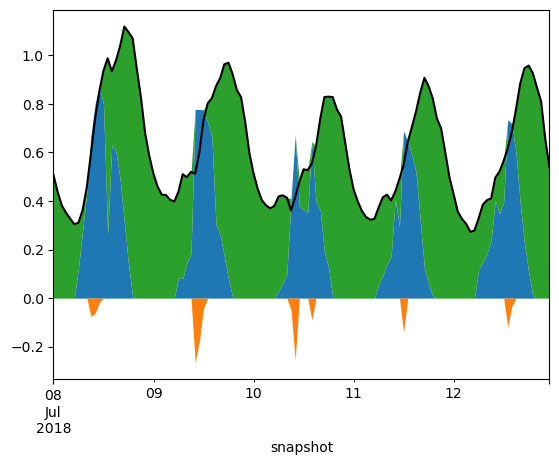

In [36]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 50% retail price for net metering
* does NOT include residential storage

In [37]:
n.generators.marginal_cost

Generator
ResPV                         0.0
Net metering Residential      0.0
Evergy Import               112.9
Name: marginal_cost, dtype: float64

In [38]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.5

In [39]:
n.generators.marginal_cost

Generator
ResPV                         0.00
Net metering Residential     56.45
Evergy Import               112.90
Name: marginal_cost, dtype: float64

In [40]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 60.33it/s]
INFO:linopy.io: Writing time: 0.71s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.77e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [41]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.331491                 0.0  2358.485524   
          net metering          2.505756                 0.0     0.000000   
          solar                 2.807000                 0.0  4135.379878   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2358.485524           0.0   
          net metering  2357.900052 -2357.900052           0.0   
          solar            0.000000  4135.379878           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.202205  0.000000e+00             0.000000   
          net metering         0.107419  0.000000e+00             0.000000   
          solar                0.168178  1.159408e-09        244069.150984   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    266273.015698  266273.015698    112.900000  
          net metering           -133103.457958 -133103.457958           NaN  
          solar                        0.000000  255898.612865     61.880316  
Load      -                            0.000000 -389068.170605           NaN

In [42]:
model_lcoe_4 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_4

91.20934940819072

<Axes: xlabel='snapshot'>

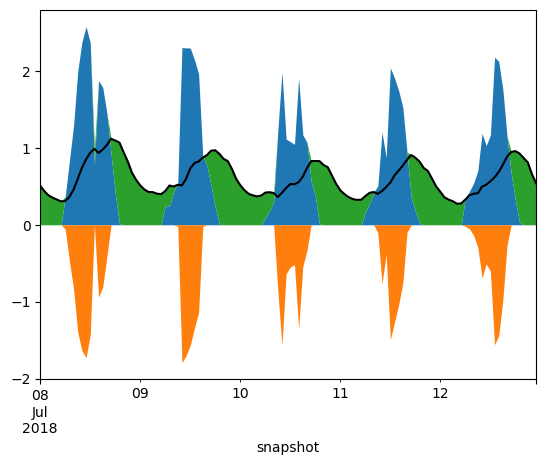

In [43]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 99% retail price for net metering
* does NOT include residential storage

In [44]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*1.00

In [45]:
n.generators.marginal_cost

Generator
ResPV                         0.0
Net metering Residential    112.9
Evergy Import               112.9
Name: marginal_cost, dtype: float64

In [46]:
n.generators.loc['ResPV', 'p_nom_max'] = 2.807

In [47]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 69.62it/s]
INFO:linopy.io: Writing time: 0.63s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 2.44e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [48]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.331491                 0.0  2358.485524   
          net metering          2.505756                 0.0     0.000000   
          solar                 2.807000                 0.0  4135.379878   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2358.485524           0.0   
          net metering  2357.900052 -2357.900052           0.0   
          solar            0.000000  4135.379878           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.202205  0.000000e+00             0.000000   
          net metering         0.107419  0.000000e+00             0.000000   
          solar                0.168178  1.159408e-09        244069.150984   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    266273.015698  266273.015698         112.9  
          net metering           -266206.915917 -266206.915917           NaN  
          solar                        0.000000  466884.388204         112.9  
Load      -                            0.000000 -466950.487985           NaN

In [49]:
model_lcoe_5 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_5

59.02739266934207

<Axes: xlabel='snapshot'>

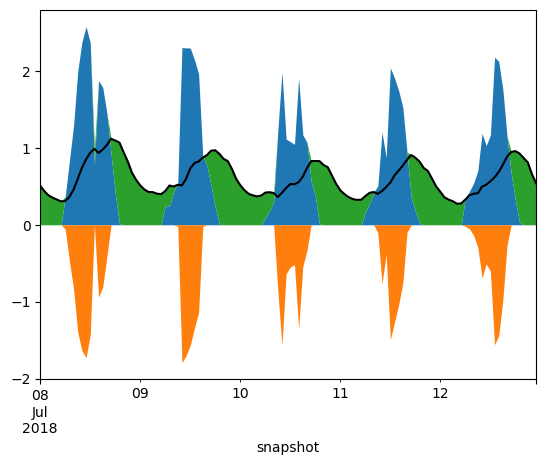

In [50]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)